# Importing Libraries

We first import all the necessary libraries and modules.

We are going to use [Trinh Hoang Trieu](https://github.com/thtrieu)'s wonderful [Darkflow](https://github.com/thtrieu/darkflow), which is an implementation of [YOLO](https://arxiv.org/abs/1506.02640) and [YOLOv2](https://arxiv.org/pdf/1612.08242.pdf) in Tensorflow. 

You only look once (YOLO) is a state-of-the-art, real-time object detection system that was first implemented in ***Joseph Redmon***'s [DarkNet](https://pjreddie.com/darknet/).

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import pprint as pp
import tensorflow as tf
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from pathlib import Path
from PIL import Image, ImageEnhance
from darkflow.net.build import TFNet

%matplotlib inline

C:\Users\RAJDEEP\Anaconda\Anaconda3\envs\tf1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\RAJDEEP\Anaconda\Anaconda3\envs\tf1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\RAJDEEP\Anaconda\Anaconda3\envs\tf1.14\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\RAJDEEP\Anaconda\Anaconda3\e

In [2]:
tf.__version__

'1.14.0'

# Setting Up

## Dataset Directories

The folder "data" contains the actual dataset with 601 annotations and images each in the "annot_chem4" folder and "images_chem4" respectively.

The images are in '.jpg' format while the annotations are '.xml' files.

In [4]:
img_path = Path("./data/images_chem4")
annot_path = Path("./data/annot_chem4")

## Creating a Custom CFG

We need to first copy the "yolo.cfg" file or whatever configuration file you are going to use in the "/cfg" folder and make some changes to it. 

- In the last section/layer of the file i.e. **[region]**, change the value of **classes** to the number of classes you want to predict on. Here, we change it to **2**, since we are only going to detect "Scratch_or_spot" and "Dent", out of all the different types of damages present in the annotations. 

- In the 2nd last section i.e. **[convolutional]**, set the value of **filters** to num\*(classes+5) (Note: **num** is present under **[region]**). In our case, we set **filters**=5\*(2+5)=35. 

Save the modified cfg as "yolo-custom.cfg".

In [5]:
cfg_path = Path("./cfg/yolo-custom.cfg")

## Changing the Labels

We also need to modify the "labels.txt" file to contain only the classes we are going to detect. Again, for our case, we change the contents of "labels.txt" to contain only "Scratch_or_spot" and "Dent".

## Downloading the Weights

Download the necessary pre-trained weights from [here](https://drive.google.com/drive/folders/0B1tW_VtY7onidEwyQ2FtQVplWEU). Since, here we are using YOLOv2, we'll download "yolo.weights" and place it in our working directory

In [6]:
yolo_wts_path = Path("yolo.weights")

# Exploring the Dataset

## Getting the list of XML files

In [6]:
xml_files = sorted(os.listdir(annot_path))
xml_files[:5]

['akhand_b43_0.xml',
 'akhand_b43_1.xml',
 'akhand_b43_10.xml',
 'akhand_b43_100.xml',
 'akhand_b43_101.xml']

In [7]:
n_files = len(xml_files)
n_files

601

## Displaying the Image along with the Bounding Boxes

In [8]:
def get_bbox(xml):
    tree = ET.parse(annot_path/xml)

    img_file = [i.text for i in tree.iter("filename")][0]
    damages = [i.text for i in tree.iter("name")]
    
    xmins = [int(i.text) for i in tree.iter("xmin")]
    ymins = [int(i.text) for i in tree.iter("ymin")]
    xmaxs = [int(i.text) for i in tree.iter("xmax")]
    ymaxs = [int(i.text) for i in tree.iter("ymax")]    
    bboxs = [[xmin,ymin,xmax,ymax] for xmin,ymin,xmax,ymax in zip(xmins,ymins,xmaxs,ymaxs)]
    
    return img_file, damages, bboxs

In [9]:
def draw_bbox(img_file, damages, bboxs):
    img = cv2.imread(str(img_path/img_file))
    fig = plt.figure(figsize = (10,10))
    
    print("Image File: ", img_file)
    print("Image Dimensions: ", img.shape)
    print("Damage Type --> Bounding Box: ")
    for d,bb in zip(damages,bboxs):
        print("\t", d,"-->", bb)
        
    for i,bbox in enumerate(bboxs):
        img = cv2.rectangle(img, (bbox[0],bbox[1]), (bbox[2],bbox[3]), (255,0,255), 3)
        img = cv2.putText(img, damages[i], (bbox[0], bbox[1]-5), cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.8, (255, 255, 0), 1, cv2.LINE_AA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

In [10]:
def show_imgs(xml_files):
    for xml in xml_files: 
        img_file, damages, bboxs = get_bbox(xml)
        draw_bbox(img_file, damages, bboxs)      

Image File:  akhand_b43_157.jpg
Image Dimensions:  (480, 640, 3)
Damage Type --> Bounding Box: 
	 Dislocation --> [50, 216, 91, 270]
	 Tear --> [313, 279, 377, 326]


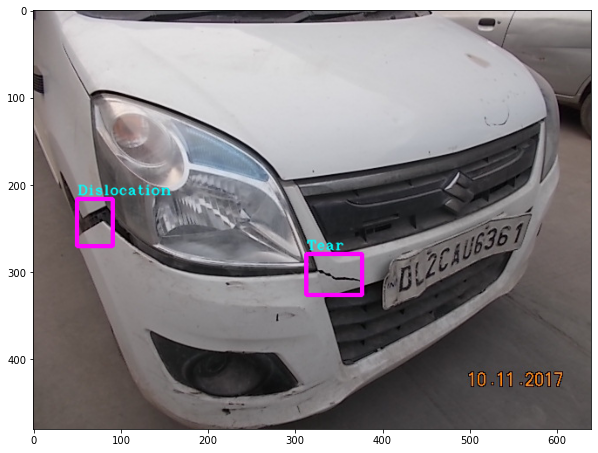

Image File:  akhand_b43_158.jpg
Image Dimensions:  (600, 800, 3)
Damage Type --> Bounding Box: 
	 Dislocation --> [173, 133, 433, 513]


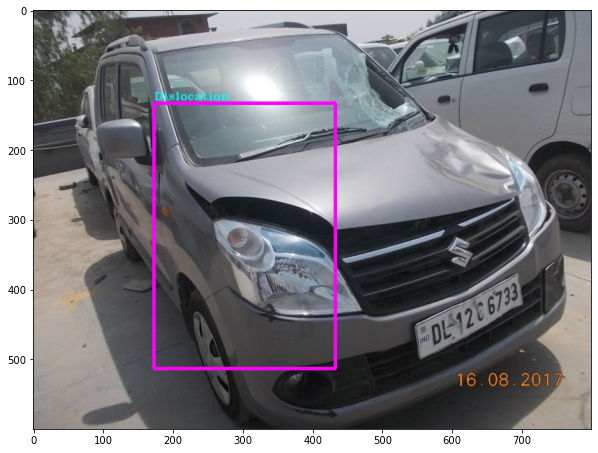

Image File:  akhand_b43_159.jpg
Image Dimensions:  (600, 800, 3)
Damage Type --> Bounding Box: 
	 Tear --> [261, 366, 350, 405]
	 Scratch_or_spot --> [635, 55, 705, 106]


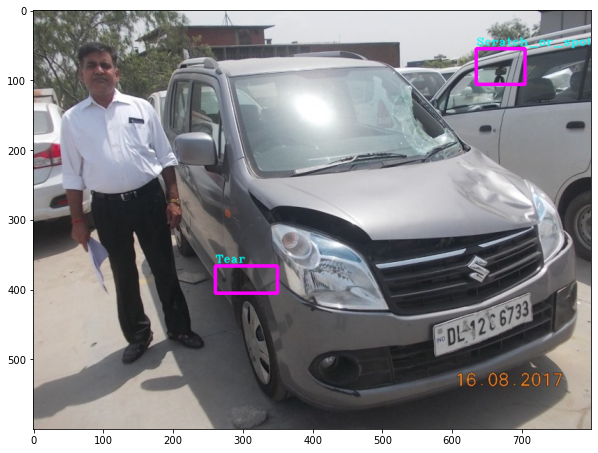

Image File:  akhand_b43_16.jpg
Image Dimensions:  (600, 800, 3)
Damage Type --> Bounding Box: 
	 Dent --> [430, 379, 471, 418]
	 Dent --> [339, 391, 414, 433]


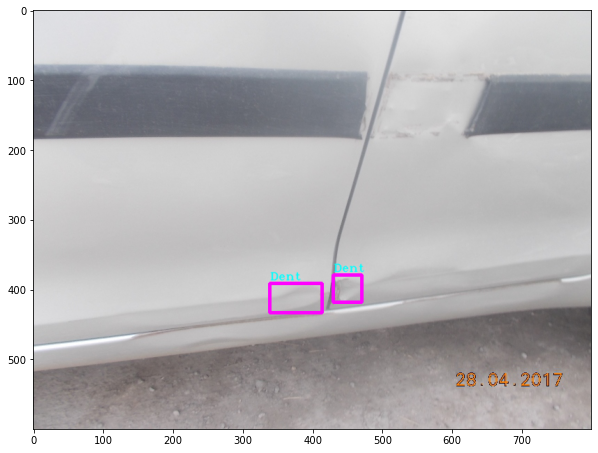

Image File:  akhand_b43_160.jpg
Image Dimensions:  (600, 800, 3)
Damage Type --> Bounding Box: 
	 Shatter --> [141, 117, 655, 461]


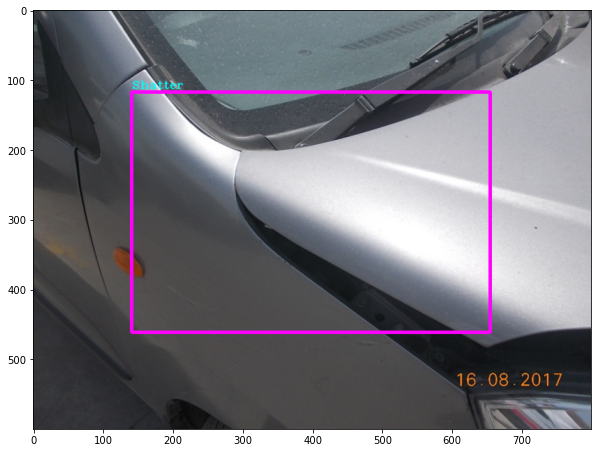

Image File:  akhand_b43_161.jpg
Image Dimensions:  (600, 800, 3)
Damage Type --> Bounding Box: 
	 Shatter --> [335, 388, 465, 577]
	 Shatter --> [121, 331, 318, 587]
	 Shatter --> [5, 403, 117, 588]


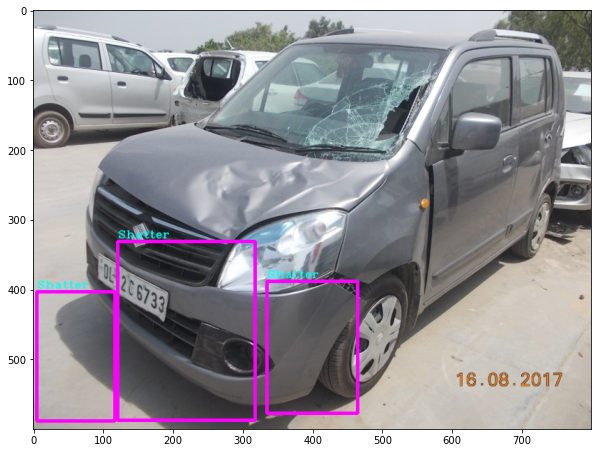

Image File:  akhand_b43_162.jpg
Image Dimensions:  (600, 800, 3)
Damage Type --> Bounding Box: 
	 Shatter --> [12, 423, 385, 592]
	 Shatter --> [187, 338, 328, 416]
	 Shatter --> [123, 367, 176, 416]


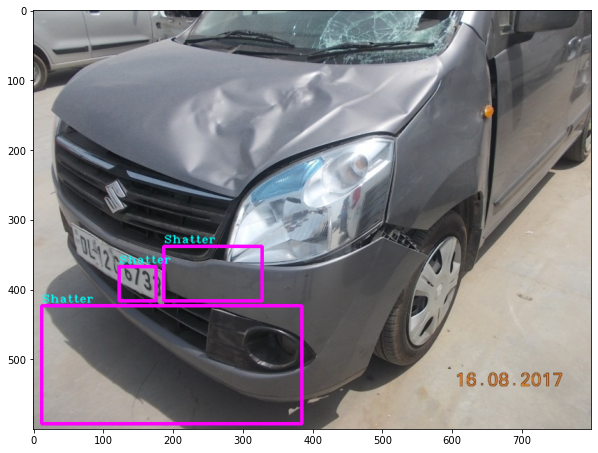

Image File:  akhand_b43_163.jpg
Image Dimensions:  (480, 640, 3)
Damage Type --> Bounding Box: 
	 Shatter --> [1, 344, 304, 471]
	 Shatter --> [134, 271, 236, 329]
	 Shatter --> [200, 234, 220, 259]


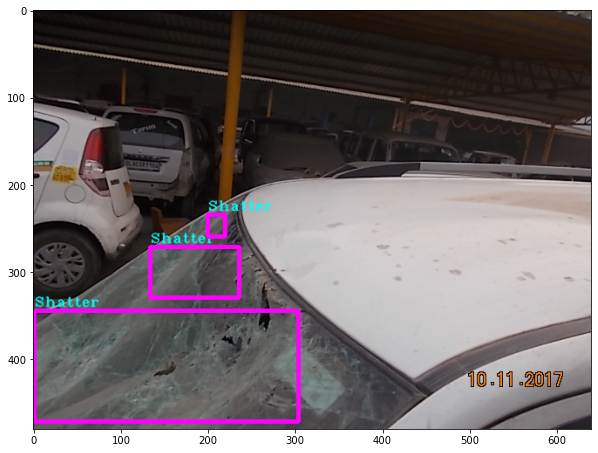

Image File:  akhand_b43_164.jpg
Image Dimensions:  (600, 800, 3)
Damage Type --> Bounding Box: 
	 Shatter --> [422, 326, 601, 596]
	 Shatter --> [606, 390, 668, 588]
	 Shatter --> [107, 358, 397, 588]
	 Shatter --> [0, 375, 71, 541]


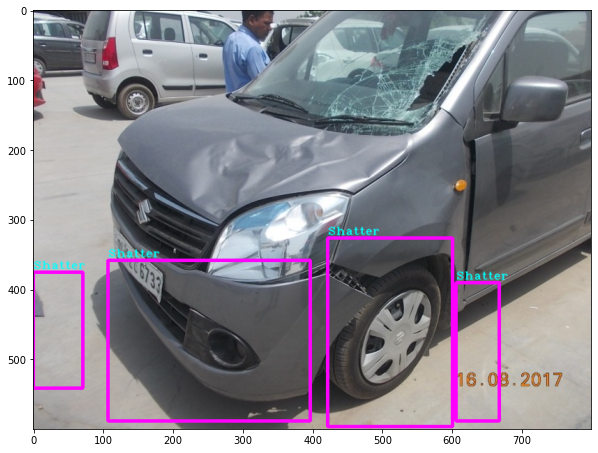

Image File:  akhand_b43_165.jpg
Image Dimensions:  (600, 800, 3)
Damage Type --> Bounding Box: 
	 Tear --> [367, 442, 1268, 669]
	 Shatter --> [358, 141, 714, 402]


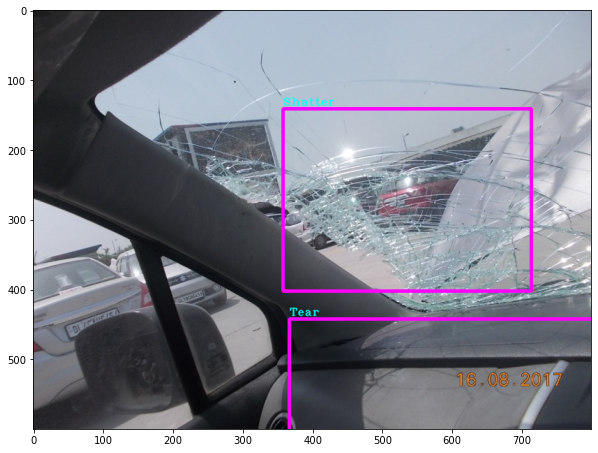

In [11]:
show_imgs(xml_files[65:75])

# Augmenting the Dataset Images

Our dataset contains only 601 images, which unfortunately is quite small. We'll try to increase our sample size by performing very basic image augmentations such as randomly changing the **color** value, **contrast**, **brightness** and **sharpness**.

We'll go over each image, augment it and save it into a different folder, to finally get 601 more images. 

In [12]:
def augment_imgs(src_img_path, dest_img_path):
    os.makedirs(dest_img_path, exist_ok = True)
    img_files = os.listdir(src_img_path)
    for i in img_files:
        img = Image.open(src_img_path/i)
        img = ImageEnhance.Color(img).enhance(np.random.uniform(0.5,1.5)) 
        img = ImageEnhance.Contrast(img).enhance(np.random.uniform(0.4,1.6))
        img = ImageEnhance.Brightness(img).enhance(np.random.uniform(0.5,1.5)) 
        img = ImageEnhance.Sharpness(img).enhance(np.random.uniform(0.6,2))
        img.save(dest_img_path/i)

In [7]:
augimg_path = Path("./data/augmented_imgs")

In [14]:
augment_imgs(img_path, augimg_path)

# Building and Training the Model

Before training, we need to define the **options** dictionary that will determine the functionality and the configuration of our model.
- "model" --> proper ".cfg" file from the "/cfg" folder i.e. configuration of the model.
- "load"  --> Weights file containing the pretrained weights for our model. If set to -1, it will load the latest checkpoint (shown later).
- "backup" --> Path to Checkpoint directory.
- "batch"  --> Batch_size / Number of images per batch.
- "epoch"  --> Total number of epochs for which to train the model.
- "gpu" --> 1 to use GPU, 0 to use CPU.
- "threshold" --> the confidence threshold.
- "save"  --> Frequency (in terms of training examples) of creating a checkpoint.
- "train" --> Boolean value to train the model or not.
- "annotation" --> Path to the folder contatining the annotation files.
- "dataset" --> Path to the folder contatining the images.

All these definitions and more are present in the "/darkflow/defaults.py" file.

# Creating a Checkpoint Folder

We need to create a folder to store the **checkpoints** as the model is being trained.

In [8]:
ckpt_path = Path("./checkpoints")

In [16]:
os.makedirs(ckpt_path, exist_ok = True)

## Training on the Augmented Images

At first, we train our model on the set of Augmented images for 5 epochs. Hence, "dataset" should be set to the path of the augmented images folder.

In [17]:
options = {"model": str(cfg_path),
           "load": str(yolo_wts_path),
           "backup": str(ckpt_path),
           "batch": 4,
           "epoch": 5,      
           "gpu": 1.0,
           "save": n_files,
           "train": True,
           "annotation": str(annot_path),
           "dataset": str(augimg_path)}

In [18]:
tfnet = TFNet(options)

Parsing ./cfg/yolo.cfg
Parsing cfg\yolo-custom.cfg
Loading yolo.weights ...
Successfully identified 203934260 bytes
Finished in 0.028512001037597656s

Building net ...

Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------



       |        | input                            | (?, 608, 608, 3)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 608, 608, 32)

 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 304, 304, 32)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 304, 304, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 152, 152, 64)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 76, 76, 128)
 Load  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?

In [19]:
tfnet.train()


cfg\yolo-custom.cfg parsing data\annot_chem4
Parsing for ['Scratch_or_spot', 'Dent'] 
[====================>]100%  akhand_b43_99.xml
Statistics:
Scratch_or_spot: 303
Dent: 177
Dataset size: 601
Dataset of 601 instance(s)
Training statistics: 
	Learning rate : 1e-05
	Batch size    : 4
	Epoch number  : 5
	Backup every  : 601
step 1 - loss 236.38851928710938 - moving ave loss 236.3885192871094
step 2 - loss 234.1214599609375 - moving ave loss 236.1618133544922
step 3 - loss 231.30575561523438 - moving ave loss 235.67620758056643
step 4 - loss 230.17056274414062 - moving ave loss 235.12564309692385
step 5 - loss 229.4374542236328 - moving ave loss 234.55682420959477
step 6 - loss 229.14129638671875 - moving ave loss 234.01527142730717
step 7 - loss 228.46588134765625 - moving ave loss 233.46033241934208
step 8 - loss 225.0281982421875 - moving ave loss 232.61711900162663
step 9 - loss 225.77178955078125 - moving ave loss 231.9325860565421
step 10 - loss 223.9527587890625 - moving ave loss

step 114 - loss 141.16929626464844 - moving ave loss 146.2153069764364
step 115 - loss 138.28269958496094 - moving ave loss 145.42204623728887
step 116 - loss 136.26287841796875 - moving ave loss 144.50612945535687
step 117 - loss 141.04293823242188 - moving ave loss 144.15981033306338
step 118 - loss 132.25204467773438 - moving ave loss 142.96903376753048
step 119 - loss 131.335205078125 - moving ave loss 141.80565089858993
step 120 - loss 134.7131805419922 - moving ave loss 141.09640386293017
step 121 - loss 133.03872680664062 - moving ave loss 140.29063615730124
step 122 - loss 136.08445739746094 - moving ave loss 139.87001828131721
step 123 - loss 128.87889099121094 - moving ave loss 138.77090555230657
step 124 - loss 130.04135131835938 - moving ave loss 137.89795012891187
step 125 - loss 129.93524169921875 - moving ave loss 137.10167928594257
step 126 - loss 128.23779296875 - moving ave loss 136.2152906542233
step 127 - loss 124.10762023925781 - moving ave loss 135.00452361272676


step 230 - loss 63.594696044921875 - moving ave loss 67.83278000943733
step 231 - loss 64.68473052978516 - moving ave loss 67.51797506147211
step 232 - loss 65.13011169433594 - moving ave loss 67.2791887247585
step 233 - loss 62.775238037109375 - moving ave loss 66.82879365599359
step 234 - loss 65.41441345214844 - moving ave loss 66.68735563560908
step 235 - loss 61.43782424926758 - moving ave loss 66.16240249697493
step 236 - loss 60.062232971191406 - moving ave loss 65.55238554439659
step 237 - loss 60.82472229003906 - moving ave loss 65.07961921896084
step 238 - loss 58.98007583618164 - moving ave loss 64.46966488068293
step 239 - loss 59.176822662353516 - moving ave loss 63.94038065884999
step 240 - loss 57.77476119995117 - moving ave loss 63.323818712960104
step 241 - loss 57.317378997802734 - moving ave loss 62.72317474144437
step 242 - loss 59.0369987487793 - moving ave loss 62.35455714217786
step 243 - loss 57.289466857910156 - moving ave loss 61.84804811375109
step 244 - loss

step 346 - loss 31.612796783447266 - moving ave loss 31.769083617761314
step 347 - loss 28.838491439819336 - moving ave loss 31.476024399967116
step 348 - loss 28.38727378845215 - moving ave loss 31.16714933881562
step 349 - loss 30.342662811279297 - moving ave loss 31.08470068606199
step 350 - loss 27.98163604736328 - moving ave loss 30.774394222192118
step 351 - loss 28.01837158203125 - moving ave loss 30.49879195817603
step 352 - loss 27.58212661743164 - moving ave loss 30.207125424101594
step 353 - loss 27.141260147094727 - moving ave loss 29.90053889640091
step 354 - loss 27.179725646972656 - moving ave loss 29.628457571458085
step 355 - loss 29.113571166992188 - moving ave loss 29.576968931011496
step 356 - loss 26.533660888671875 - moving ave loss 29.272638126777533
step 357 - loss 28.26007843017578 - moving ave loss 29.171382157117357
step 358 - loss 25.996150970458984 - moving ave loss 28.85385903845152
step 359 - loss 26.464141845703125 - moving ave loss 28.61488731917668
ste

step 461 - loss 14.861150741577148 - moving ave loss 14.671432286769507
step 462 - loss 13.741634368896484 - moving ave loss 14.578452494982205
step 463 - loss 13.064970016479492 - moving ave loss 14.427104247131934
step 464 - loss 13.219417572021484 - moving ave loss 14.30633557962089
step 465 - loss 14.389059066772461 - moving ave loss 14.314607928336049
step 466 - loss 12.129626274108887 - moving ave loss 14.096109762913333
step 467 - loss 12.584409713745117 - moving ave loss 13.944939757996512
step 468 - loss 11.38337516784668 - moving ave loss 13.688783298981528
step 469 - loss 12.872200012207031 - moving ave loss 13.60712497030408
step 470 - loss 12.703214645385742 - moving ave loss 13.516733937812246
step 471 - loss 12.158967971801758 - moving ave loss 13.380957341211197
step 472 - loss 12.835972785949707 - moving ave loss 13.32645888568505
step 473 - loss 12.75235366821289 - moving ave loss 13.269048363937834
step 474 - loss 12.215187072753906 - moving ave loss 13.1636622348194

step 577 - loss 7.326542854309082 - moving ave loss 7.882173727028333
step 578 - loss 7.389165878295898 - moving ave loss 7.83287294215509
step 579 - loss 7.222297191619873 - moving ave loss 7.771815367101569
step 580 - loss 5.048713684082031 - moving ave loss 7.499505198799615
step 581 - loss 8.16897201538086 - moving ave loss 7.566451880457739
step 582 - loss 10.436199188232422 - moving ave loss 7.853426611235208
step 583 - loss 5.333230972290039 - moving ave loss 7.601407047340691
step 584 - loss 7.010785102844238 - moving ave loss 7.542344852891047
step 585 - loss 9.021293640136719 - moving ave loss 7.690239731615614
step 586 - loss 5.722400665283203 - moving ave loss 7.493455824982374
step 587 - loss 5.844432353973389 - moving ave loss 7.328553477881476
step 588 - loss 7.761559963226318 - moving ave loss 7.37185412641596
step 589 - loss 5.929100036621094 - moving ave loss 7.227578717436474
step 590 - loss 4.55946159362793 - moving ave loss 6.96076700505562
step 591 - loss 5.067047

step 694 - loss 3.298464775085449 - moving ave loss 3.7555318757521063
step 695 - loss 3.216667890548706 - moving ave loss 3.7016454772317666
step 696 - loss 2.5603461265563965 - moving ave loss 3.5875155421642297
step 697 - loss 4.271756649017334 - moving ave loss 3.6559396528495403
step 698 - loss 3.9527792930603027 - moving ave loss 3.685623616870617
step 699 - loss 4.315710544586182 - moving ave loss 3.748632309642174
step 700 - loss 4.486467361450195 - moving ave loss 3.822415814822976
step 701 - loss 4.473334312438965 - moving ave loss 3.887507664584575
step 702 - loss 5.62522029876709 - moving ave loss 4.061278928002826
step 703 - loss 4.354015350341797 - moving ave loss 4.090552570236723
step 704 - loss 3.6740291118621826 - moving ave loss 4.0489002243992696
step 705 - loss 2.547990322113037 - moving ave loss 3.8988092341706464
step 706 - loss 1.8328896760940552 - moving ave loss 3.6922172783629876
step 707 - loss 4.907578468322754 - moving ave loss 3.813753397358964
step 708 -

## Training on the Dataset Images

Now, we train our model further but on the actual dataset images for another 12 epochs. Hence, "dataset" should be the path of the folder containing the dataset images. This time, however, we set "load" to -1, since we want to load the latest checkpoint generated over the previous training period.

In [20]:
options = {"model": str(cfg_path),
           "load": -1,
           "backup": str(ckpt_path),
           "batch": 4,
           "epoch": 12,     
           "gpu": 1.0,
           "save": n_files,
           "train": True,
           "annotation": str(annot_path),
           "dataset": str(img_path)}

In [21]:
tfnet = TFNet(options)

Parsing cfg\yolo-custom.cfg
Loading None ...
Finished in 0.0s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 608, 608, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 608, 608, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 304, 304, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 304, 304, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 152, 152, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Init  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 152, 152, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 76, 76, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 76, 76, 256)
 Init  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 76, 76, 128)
 Init  |

In [22]:
tfnet.train()


cfg\yolo-custom.cfg parsing data\annot_chem4
Parsing for ['Scratch_or_spot', 'Dent'] 
[====================>]100%  akhand_b43_99.xml
Statistics:
Scratch_or_spot: 303
Dent: 177
Dataset size: 601
Dataset of 601 instance(s)
Training statistics: 
	Learning rate : 1e-05
	Batch size    : 4
	Epoch number  : 12
	Backup every  : 601
step 751 - loss 3.20621395111084 - moving ave loss 3.20621395111084
step 752 - loss 1.2727423906326294 - moving ave loss 3.012866795063019
step 753 - loss 1.9257519245147705 - moving ave loss 2.9041553080081943
step 754 - loss 3.7333548069000244 - moving ave loss 2.9870752578973776
step 755 - loss 3.1964964866638184 - moving ave loss 3.008017380774022
step 756 - loss 3.795069694519043 - moving ave loss 3.086722612148524
step 757 - loss 4.001372337341309 - moving ave loss 3.1781875846678025
step 758 - loss 3.077463150024414 - moving ave loss 3.168115141203464
step 759 - loss 5.2156805992126465 - moving ave loss 3.3728716870043822
step 760 - loss 4.295527458190918 - 

step 862 - loss 5.391687393188477 - moving ave loss 2.90840267804675
step 863 - loss 4.476476192474365 - moving ave loss 3.0652100294895117
step 864 - loss 1.630192756652832 - moving ave loss 2.921708302205844
step 865 - loss 3.186387300491333 - moving ave loss 2.948176202034393
step 866 - loss 1.9609532356262207 - moving ave loss 2.8494539053935757
step 867 - loss 3.0809571743011475 - moving ave loss 2.872604232284333
step 868 - loss 1.8506633043289185 - moving ave loss 2.7704101394887917
step 869 - loss 3.028809070587158 - moving ave loss 2.7962500325986284
step 870 - loss 1.8939127922058105 - moving ave loss 2.7060163085593465
step 871 - loss 2.342716932296753 - moving ave loss 2.669686370933087
step 872 - loss 4.867564678192139 - moving ave loss 2.889474201658992
step 873 - loss 1.6641080379486084 - moving ave loss 2.7669375852879536
step 874 - loss 1.7377289533615112 - moving ave loss 2.6640167220953095
step 875 - loss 1.2650225162506104 - moving ave loss 2.52411730151084
step 876

step 977 - loss 1.63326096534729 - moving ave loss 2.4440627109896007
step 978 - loss 1.4593006372451782 - moving ave loss 2.345586503615159
step 979 - loss 0.24325664341449738 - moving ave loss 2.1353535175950924
step 980 - loss 4.778140068054199 - moving ave loss 2.3996321726410033
step 981 - loss 2.938284158706665 - moving ave loss 2.453497371247569
step 982 - loss 1.5294920206069946 - moving ave loss 2.3610968361835116
step 983 - loss 3.5062129497528076 - moving ave loss 2.4756084475404414
step 984 - loss 3.6735177040100098 - moving ave loss 2.5953993731873983
step 985 - loss 1.3619441986083984 - moving ave loss 2.4720538557294987
step 986 - loss 2.1138663291931152 - moving ave loss 2.4362351030758607
step 987 - loss 3.17929744720459 - moving ave loss 2.5105413374887338
step 988 - loss 1.6901522874832153 - moving ave loss 2.428502432488182
step 989 - loss 4.6265974044799805 - moving ave loss 2.648311929687362
step 990 - loss 2.834056854248047 - moving ave loss 2.6668864221434303
st

step 1091 - loss 2.087143659591675 - moving ave loss 2.1838766570775334
step 1092 - loss 0.8856897950172424 - moving ave loss 2.0540579708715043
step 1093 - loss 2.781618356704712 - moving ave loss 2.1268140094548253
step 1094 - loss 1.1600422859191895 - moving ave loss 2.030136837101262
step 1095 - loss 1.6203598976135254 - moving ave loss 1.9891591431524882
step 1096 - loss 2.843517541885376 - moving ave loss 2.074594983025777
step 1097 - loss 2.504045248031616 - moving ave loss 2.117540009526361
step 1098 - loss 3.662895441055298 - moving ave loss 2.272075552679255
step 1099 - loss 0.7035670876502991 - moving ave loss 2.1152247061763596
step 1100 - loss 1.5407885313034058 - moving ave loss 2.0577810886890644
step 1101 - loss 4.163232326507568 - moving ave loss 2.2683262124709147
step 1102 - loss 3.493758201599121 - moving ave loss 2.3908694113837354
step 1103 - loss 3.3192052841186523 - moving ave loss 2.483702998657227
step 1104 - loss 5.228061199188232 - moving ave loss 2.75813881

step 1204 - loss 0.7630261182785034 - moving ave loss 1.8597774514705063
step 1205 - loss 1.4895448684692383 - moving ave loss 1.8227541931703797
step 1206 - loss 0.10307613015174866 - moving ave loss 1.6507863868685166
step 1207 - loss 1.4982901811599731 - moving ave loss 1.6355367662976623
step 1208 - loss 1.4497774839401245 - moving ave loss 1.6169608380619085
step 1209 - loss 0.9285186529159546 - moving ave loss 1.5481166195473133
step 1210 - loss 3.0493581295013428 - moving ave loss 1.6982407705427163
step 1211 - loss 0.7077165246009827 - moving ave loss 1.599188345948543
step 1212 - loss 1.4477072954177856 - moving ave loss 1.5840402408954672
step 1213 - loss 1.2108581066131592 - moving ave loss 1.5467220274672364
step 1214 - loss 1.3406894207000732 - moving ave loss 1.5261187667905203
step 1215 - loss 1.935054063796997 - moving ave loss 1.567012296491168
step 1216 - loss 2.1870012283325195 - moving ave loss 1.629011189675303
step 1217 - loss 1.2807674407958984 - moving ave loss 

step 1318 - loss 1.4303038120269775 - moving ave loss 1.9206159967972987
step 1319 - loss 0.18138572573661804 - moving ave loss 1.7466929696912306
step 1320 - loss 2.320641040802002 - moving ave loss 1.8040877768023078
step 1321 - loss 1.5531078577041626 - moving ave loss 1.7789897848924934
step 1322 - loss 1.4593524932861328 - moving ave loss 1.7470260557318573
step 1323 - loss 2.694990634918213 - moving ave loss 1.8418225136504929
step 1324 - loss 2.031691074371338 - moving ave loss 1.8608093697225774
step 1325 - loss 2.527785301208496 - moving ave loss 1.9275069628711692
step 1326 - loss 0.6441676616668701 - moving ave loss 1.7991730327507394
step 1327 - loss 5.7940802574157715 - moving ave loss 2.1986637552172428
step 1328 - loss 0.6536414623260498 - moving ave loss 2.0441615259281236
step 1329 - loss 0.40654993057250977 - moving ave loss 1.8804003663925624
step 1330 - loss 3.63946533203125 - moving ave loss 2.056306862956431
step 1331 - loss 0.8231108784675598 - moving ave loss 1.

step 1431 - loss 3.3504152297973633 - moving ave loss 1.7495742522000148
step 1432 - loss 0.8052563667297363 - moving ave loss 1.655142463652987
step 1433 - loss 0.037261713296175 - moving ave loss 1.4933543886173057
step 1434 - loss 1.9905987977981567 - moving ave loss 1.543078829535391
step 1435 - loss 3.121861457824707 - moving ave loss 1.7009570923643227
step 1436 - loss 1.465429663658142 - moving ave loss 1.6774043494937048
step 1437 - loss 1.2815245389938354 - moving ave loss 1.6378163684437177
step 1438 - loss 1.341292142868042 - moving ave loss 1.6081639458861503
step 1439 - loss 1.0017659664154053 - moving ave loss 1.5475241479390758
step 1440 - loss 0.7041130661964417 - moving ave loss 1.4631830397648125
step 1441 - loss 0.5130985379219055 - moving ave loss 1.3681745895805217
step 1442 - loss 2.099266767501831 - moving ave loss 1.4412838073726526
step 1443 - loss 0.5822423100471497 - moving ave loss 1.3553796576401023
step 1444 - loss 1.1431999206542969 - moving ave loss 1.33

step 1544 - loss 0.8960462212562561 - moving ave loss 1.7639188385216742
step 1545 - loss 1.940936803817749 - moving ave loss 1.7816206350512818
step 1546 - loss 1.1158335208892822 - moving ave loss 1.7150419236350818
step 1547 - loss 0.7337781190872192 - moving ave loss 1.6169155431802955
step 1548 - loss 1.709059238433838 - moving ave loss 1.6261299127056499
step 1549 - loss 1.3121633529663086 - moving ave loss 1.5947332567317158
step 1550 - loss 2.864459991455078 - moving ave loss 1.721705930204052
step 1551 - loss 0.0387248694896698 - moving ave loss 1.553407824132614
step 1552 - loss 3.902566432952881 - moving ave loss 1.7883236850146407
step 1553 - loss 3.7449965476989746 - moving ave loss 1.9839909712830741
step 1554 - loss 0.695590078830719 - moving ave loss 1.8551508820378386
step 1555 - loss 1.3795315027236938 - moving ave loss 1.8075889441064241
step 1556 - loss 1.7592442035675049 - moving ave loss 1.8027544700525322
step 1557 - loss 0.7076331973075867 - moving ave loss 1.69

step 1657 - loss 3.1857004165649414 - moving ave loss 2.229413341212887
step 1658 - loss 0.9213533401489258 - moving ave loss 2.098607341106491
step 1659 - loss 1.2314870357513428 - moving ave loss 2.011895310570976
step 1660 - loss 0.7240673899650574 - moving ave loss 1.8831125185103843
step 1661 - loss 1.8493748903274536 - moving ave loss 1.8797387556920913
step 1662 - loss 2.136676549911499 - moving ave loss 1.905432535114032
step 1663 - loss 1.9115933179855347 - moving ave loss 1.9060486134011825
step 1664 - loss 3.9733986854553223 - moving ave loss 2.1127836206065966
step 1665 - loss 5.199309349060059 - moving ave loss 2.421436193451943
step 1666 - loss 1.907138466835022 - moving ave loss 2.3700064207902507
step 1667 - loss 2.7362537384033203 - moving ave loss 2.4066311525515576
step 1668 - loss 2.381357192993164 - moving ave loss 2.404103756595718
step 1669 - loss 2.387773036956787 - moving ave loss 2.402470684631825
step 1670 - loss 0.04868587106466293 - moving ave loss 2.167092

step 1770 - loss 0.03845299035310745 - moving ave loss 1.6426074680376315
step 1771 - loss 2.053481101989746 - moving ave loss 1.683694831432843
step 1772 - loss 0.6733219623565674 - moving ave loss 1.5826575445252156
step 1773 - loss 1.8689980506896973 - moving ave loss 1.611291595141664
step 1774 - loss 1.7399691343307495 - moving ave loss 1.6241593490605726
step 1775 - loss 1.5803937911987305 - moving ave loss 1.6197827932743885
step 1776 - loss 3.6226649284362793 - moving ave loss 1.8200710067905774
step 1777 - loss 2.694830894470215 - moving ave loss 1.9075469955585411
step 1778 - loss 1.9733083248138428 - moving ave loss 1.9141231284840714
step 1779 - loss 1.9931366443634033 - moving ave loss 1.9220244800720048
step 1780 - loss 2.497030735015869 - moving ave loss 1.9795251055663914
step 1781 - loss 1.661147117614746 - moving ave loss 1.9476873067712268
step 1782 - loss 4.364755153656006 - moving ave loss 2.1893940914597048
step 1783 - loss 1.4014804363250732 - moving ave loss 2.1

step 1883 - loss 1.8559852838516235 - moving ave loss 1.5399828244900546
step 1884 - loss 1.3376801013946533 - moving ave loss 1.5197525521805146
step 1885 - loss 2.033414602279663 - moving ave loss 1.5711187571904297
step 1886 - loss 3.183183193206787 - moving ave loss 1.7323252007920655
step 1887 - loss 3.0688230991363525 - moving ave loss 1.8659749906264944
step 1888 - loss 1.0249297618865967 - moving ave loss 1.7818704677525048
step 1889 - loss 0.08129218965768814 - moving ave loss 1.6118126399430233
step 1890 - loss 0.904057502746582 - moving ave loss 1.5410371262233793
step 1891 - loss 1.9368242025375366 - moving ave loss 1.580615833854795
step 1892 - loss 1.788845419883728 - moving ave loss 1.6014387924576885
step 1893 - loss 1.2708033323287964 - moving ave loss 1.5683752464447993
step 1894 - loss 1.742255687713623 - moving ave loss 1.5857632905716816
step 1895 - loss 0.15473298728466034 - moving ave loss 1.4426602602429794
step 1896 - loss 1.3477027416229248 - moving ave loss 1

step 1996 - loss 4.1152448654174805 - moving ave loss 1.9204425800834897
step 1997 - loss 2.3595120906829834 - moving ave loss 1.964349531143439
step 1998 - loss 0.023478837683796883 - moving ave loss 1.7702624617974747
step 1999 - loss 1.7640047073364258 - moving ave loss 1.76963668635137
step 2000 - loss 1.5383038520812988 - moving ave loss 1.746503402924363
step 2001 - loss 0.545543372631073 - moving ave loss 1.626407399895034
step 2002 - loss 2.4028093814849854 - moving ave loss 1.704047598054029
step 2003 - loss 1.3410829305648804 - moving ave loss 1.6677511313051143
step 2004 - loss 1.2893422842025757 - moving ave loss 1.6299102465948605
step 2005 - loss 1.5420341491699219 - moving ave loss 1.6211226368523666
step 2006 - loss 1.1857678890228271 - moving ave loss 1.5775871620694126
step 2007 - loss 2.4882895946502686 - moving ave loss 1.6686574053274983
step 2008 - loss 1.8255873918533325 - moving ave loss 1.6843504039800816
step 2009 - loss 2.503162145614624 - moving ave loss 1.7

step 2109 - loss 1.9792451858520508 - moving ave loss 1.9065222766297834
step 2110 - loss 0.7010895609855652 - moving ave loss 1.7859790050653617
step 2111 - loss 1.524322271347046 - moving ave loss 1.7598133316935303
step 2112 - loss 3.1936445236206055 - moving ave loss 1.903196450886238
step 2113 - loss 2.055467128753662 - moving ave loss 1.9184235186729806
step 2114 - loss 1.6400638818740845 - moving ave loss 1.890587554993091
step 2115 - loss 2.300644636154175 - moving ave loss 1.9315932631091994
step 2116 - loss 0.024310175329446793 - moving ave loss 1.7408649543312242
step 2117 - loss 0.8315331339836121 - moving ave loss 1.649931772296463
step 2118 - loss 1.3956985473632812 - moving ave loss 1.624508449803145
step 2119 - loss 3.2452008724212646 - moving ave loss 1.7865776920649572
step 2120 - loss 0.7070581316947937 - moving ave loss 1.6786257360279409
step 2121 - loss 2.493711233139038 - moving ave loss 1.7601342857390505
step 2122 - loss 1.4130767583847046 - moving ave loss 1.7

step 2223 - loss 2.745807647705078 - moving ave loss 1.98351876275753
step 2224 - loss 2.9261929988861084 - moving ave loss 2.0777861863703877
step 2225 - loss 0.02868606708943844 - moving ave loss 1.8728761744422928
step 2226 - loss 2.5481834411621094 - moving ave loss 1.9404069011142746
step 2227 - loss 0.8330314755439758 - moving ave loss 1.8296693585572448
step 2228 - loss 0.4505782127380371 - moving ave loss 1.691760243975324
step 2229 - loss 0.8777449727058411 - moving ave loss 1.6103587168483757
step 2230 - loss 1.2127389907836914 - moving ave loss 1.5705967442419073
step 2231 - loss 3.302182674407959 - moving ave loss 1.7437553372585124
step 2232 - loss 0.6992798447608948 - moving ave loss 1.6393077880087505
step 2233 - loss 0.9080117344856262 - moving ave loss 1.566178182656438
step 2234 - loss 0.3877640962600708 - moving ave loss 1.4483367740168014
step 2235 - loss 0.7530924677848816 - moving ave loss 1.3788123433936095
step 2236 - loss 0.13442429900169373 - moving ave loss 1

step 2336 - loss 3.202305316925049 - moving ave loss 2.5256850699372073
step 2337 - loss 2.794585943222046 - moving ave loss 2.5525751572656916
step 2338 - loss 0.03774610534310341 - moving ave loss 2.3010922520734325
step 2339 - loss 0.2428206503391266 - moving ave loss 2.095265091900002
step 2340 - loss 3.194720506668091 - moving ave loss 2.205210633376811
step 2341 - loss 2.549983263015747 - moving ave loss 2.2396878963407048
step 2342 - loss 1.547379493713379 - moving ave loss 2.1704570560779723
step 2343 - loss 1.365172266960144 - moving ave loss 2.0899285771661895
step 2344 - loss 1.424098014831543 - moving ave loss 2.023345520932725
step 2345 - loss 2.188173770904541 - moving ave loss 2.0398283459299065
step 2346 - loss 0.8572912216186523 - moving ave loss 1.921574633498781
step 2347 - loss 0.02552741765975952 - moving ave loss 1.7319699119148788
step 2348 - loss 0.6914159059524536 - moving ave loss 1.6279145113186362
step 2349 - loss 1.3698790073394775 - moving ave loss 1.60211

step 2449 - loss 2.1172993183135986 - moving ave loss 1.7410021194921772
step 2450 - loss 1.0180878639221191 - moving ave loss 1.6687106939351715
step 2451 - loss 1.2872672080993652 - moving ave loss 1.6305663453515908
step 2452 - loss 1.5061063766479492 - moving ave loss 1.6181203484812268
step 2453 - loss 4.328686714172363 - moving ave loss 1.8891769850503404
step 2454 - loss 2.4074461460113525 - moving ave loss 1.9410039011464417
step 2455 - loss 5.267913818359375 - moving ave loss 2.273694892867735
step 2456 - loss 0.4065215587615967 - moving ave loss 2.0869775594571216
step 2457 - loss 1.627687692642212 - moving ave loss 2.0410485727756305
step 2458 - loss 0.9573519229888916 - moving ave loss 1.9326789077969566
step 2459 - loss 1.2901413440704346 - moving ave loss 1.8684251514243044
step 2460 - loss 0.4781162142753601 - moving ave loss 1.72939425770941
step 2461 - loss 3.7734546661376953 - moving ave loss 1.9338002985522387
step 2462 - loss 0.9339410662651062 - moving ave loss 1.8

# mAP scores and Plots

We'll take help of the wonderful [Object Detection Metrics](https://github.com/rafaelpadilla/Object-Detection-Metrics) repository. Download and copy the following into the working directory:-
- pascalvoc.py
- _init_paths.py
- lib module

## Groundtruths

We'll need to create a folder that will contain all our groundtruth labels and bounding boxes in text format as described in the Object Detection Metrics repo linked above. For example, for an image "XYZ.jpg", we'll need to create a text file "XYZ.txt" that contains the class labels and bounding boxes in the format 
`<class_name> <left> <top> <right> <bottom>` or `<class_name> <xmin> <ymin> <xmax> <ymax>`.

In [23]:
def create_groundtruth_txts(groundtruth_folder, annot_path):
    os.makedirs(groundtruth_folder, exist_ok = True)
    
    xml_files = os.listdir(annot_path)
    for xml in xml_files:
        name = xml.split(".")[0]
        text = os.path.join(groundtruth_folder, name + ".txt")
        _, damages, bboxs = get_bbox(xml)
        with open(text, 'w') as f:
            for d,bb in zip(damages, bboxs):
                f.write(d + " " + str(bb[0]) + " " + str(bb[1]) + " " + str(bb[2]) + " " + str(bb[3]) + "\n")

In [24]:
groundtruth_folder = Path("./groundtruths")

In [25]:
create_groundtruth_txts(groundtruth_folder, annot_path)

## Detections

Similarly, we'll create a folder that will contain all our predicted/detected labels and bounding boxes in text format, in the format `<class_name> <left> <top> <right> <bottom>` or `<class_name> <xmin> <ymin> <xmax> <ymax>` 

In [26]:
def create_detections_txts(prediction_folder, img_path):
    os.makedirs(prediction_folder, exist_ok = True)
    
    img_files = os.listdir(img_path)
    for file in img_files:
        img = cv2.imread(str(img_path/file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        name = file.split(".")[0]
        text = os.path.join(prediction_folder, name + ".txt")
        results = tfnet.return_predict(img)
        with open(text, 'w') as f:
            for i in results:
                f.write(i['label'] + ' ' + str(i['confidence']) + ' ' + str(i['topleft']['x']) + ' ' + str(i['topleft']['y'])
                            + ' ' + str(i['bottomright']['x']) + ' ' + str(i['bottomright']['y']) + '\n')

In [27]:
prediction_folder = Path("./detections")

In [28]:
create_detections_txts(prediction_folder, img_path)

## Generating the Plots and Scores

After running the following cell, the plots that are generated are saved in a "results" folder.

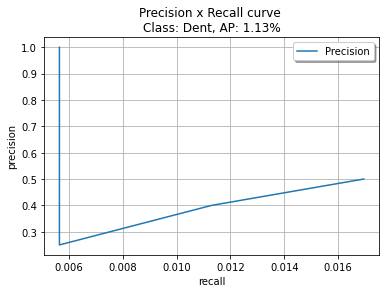

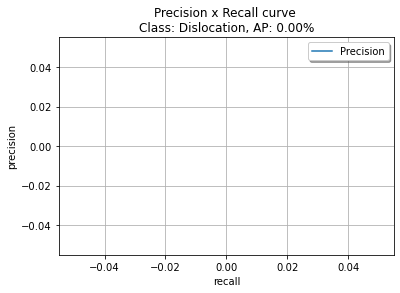

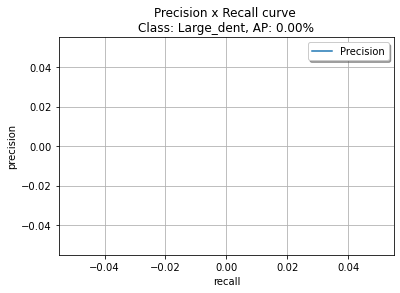

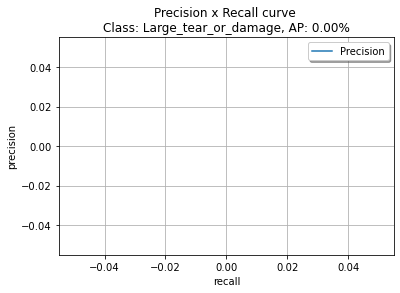

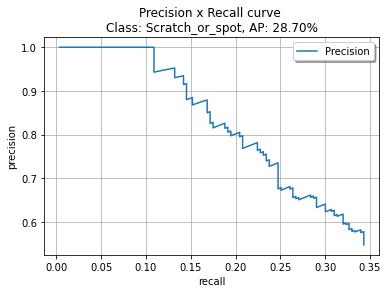

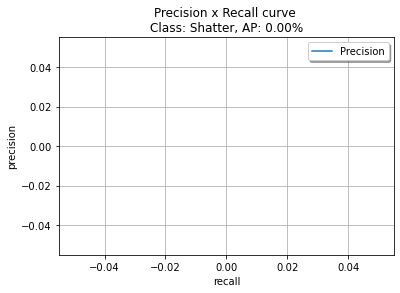

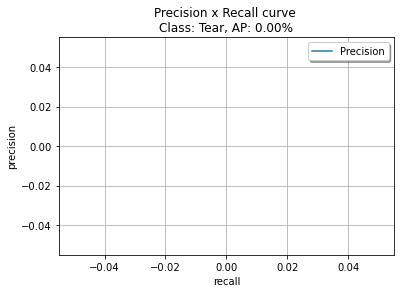

AP: 1.13% (Dent)
AP: 0.00% (Dislocation)
AP: 0.00% (Large_dent)
AP: 0.00% (Large_tear_or_damage)
AP: 28.70% (Scratch_or_spot)
AP: 0.00% (Shatter)
AP: 0.00% (Tear)
mAP: 4.26%


<Figure size 432x288 with 0 Axes>

In [29]:
%run pascalvoc.py

# Testing out Sample Images

We now test our model on a few sample/test images.

In [16]:
confidence_threshold = 0.01

In [17]:
options = {"model": str(cfg_path),
           "threshold": confidence_threshold,   
           "load": -1,                          
           "gpu": 1,
           "backup": str(ckpt_path)}                            

In [18]:
tfnet_predict = TFNet(options)

Parsing cfg\yolo-custom.cfg
Loading None ...
Finished in 0.0s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 608, 608, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 608, 608, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 304, 304, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 304, 304, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 152, 152, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Init  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 152, 152, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 76, 76, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 76, 76, 256)
 Init  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 76, 76, 128)
 Init  |

In [19]:
def predicted_bbox(img , predictions, threshold):
    fig = plt.figure(figsize = (10,10))  
    for pred in predictions:
        xmin = pred['topleft']['x']
        ymin = pred['topleft']['y']
        xmax = pred['bottomright']['x']
        ymax = pred['bottomright']['y']
        confidence = pred['confidence']
        label = pred['label'] + " " + str(round(confidence, 3))     
           
        if confidence > threshold:
            img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255,0,0), 3)
            img = cv2.putText(img, label, (xmin, ymin-5), cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.8, (0, 230, 0), 1, cv2.LINE_AA)

    plt.imshow(img)
    plt.show()

In [20]:
def test(testimg_path, threshold):
    img_files = os.listdir(testimg_path)
    for file in img_files:
        img = cv2.imread(str(testimg_path/file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        predictions = tfnet_predict.return_predict(img)
        predicted_bbox(img , predictions, threshold)

In [21]:
testimg_path = Path("./test_imgs")

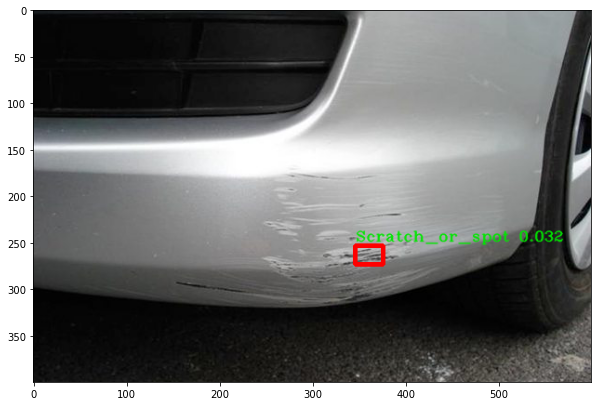

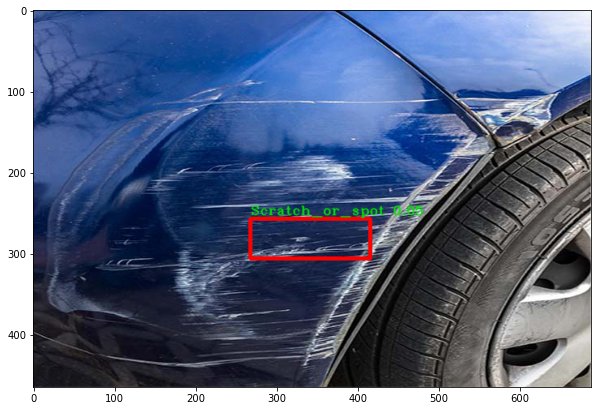

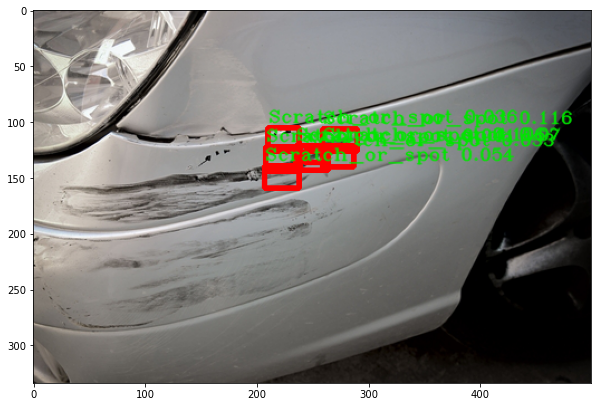

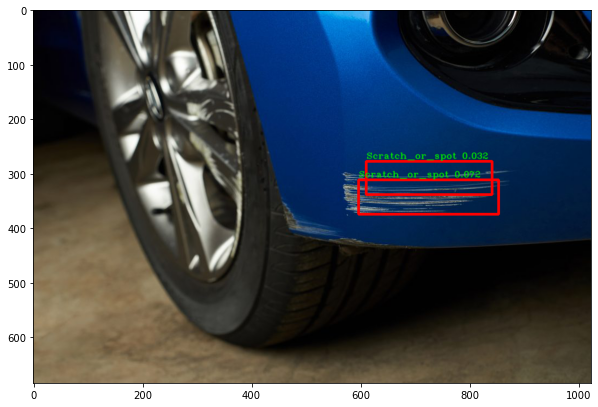

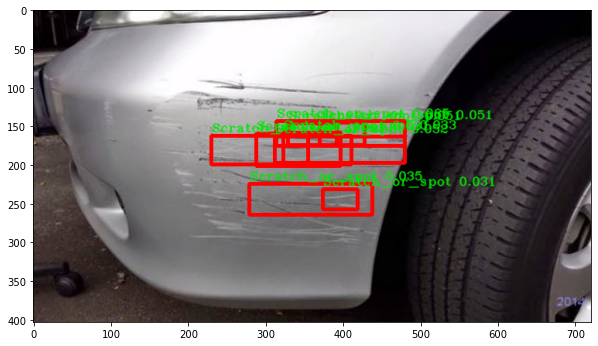

In [29]:
test(testimg_path, threshold = 0.03)

The Model can be improved further as it is not yet able to identify every type Scratch or Dent properly. One way to tackle this is getting more data and using better augmentation techniques. 

# References:-    

- https://github.com/thtrieu/darkflow


- https://github.com/pjreddie/darknet


- https://towardsdatascience.com/yolov2-to-detect-your-own-objects-soccer-ball-using-darkflow-a4f98d5ce5bf


- https://github.com/deep-diver/Soccer-Ball-Detection-YOLOv2


- https://github.com/deep-diver/Object-Detection-YOLOv2-Darkflow


- https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173


- https://github.com/rafaelpadilla/Object-Detection-Metrics